


## <center> A Machine Learning Approach to U.S. Inflation Prediction </center>
#### <u>Biruk Tefera</u>
#### <u>May 14/2025</u>
#### <u>COSC-247: Machine Learning</u>


#### 1. Idea

This project is about forecasting U.S. inflation, which is a big part of macroeconomics and super important for policymakers like the Federal Reserve. They watch inflation closely because it affects everything from interest rates to job growth. The goal is to build ML models that can help predict where inflation is headed and see if they can perform better than traditional econometric models.

The main goal is to find out whether machine learning can predict U.S. inflation better than traditional economic models. Inflation is tough to forecast because economies are so complex and always changing, especially during major events like financial crises or pandemics. I believe Machine learning models can handle lots of variables and uncover hidden patterns that classic models might miss. I also want to test if combining economic theory (specifically the Phillips Curve) with machine learning can make the predictions more accurate and reliable.

#### 2. Import Libraries

In [1]:
#importing numpy and pandas
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#traditional econometric models OLS
import statsmodels.api as sm

#machine Learning models 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

#model evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#train/test split and Hyperparameter Tuning
from sklearn.model_selection import train_test_split, GridSearchCV


#### 3. Load Individual Data Sets

In [2]:
#CPI data set
#Link: https://fred.stlouisfed.org/series/CPIAUCSL
cpi = pd.read_csv("CPI.csv")
#Convert CPI to actual Inflation by calculating the rate change of CPI in percentage terms
cpi['Inflation'] = cpi['CPIAUCSL'].pct_change(periods=12) * 100
cpi = cpi.dropna()

cpi.head()

,observation_date,CPIAUCSL,Inflation
12,1948-01-01,23.68,10.242086
13,1948-02-01,23.67,9.481961
14,1948-03-01,23.50,6.818182
15,1948-04-01,23.82,8.272727
16,1948-05-01,24.01,9.384966


In [3]:
#unemployment rate data set
#Link: https://fred.stlouisfed.org/series/U2RATE
UNRATE = pd.read_csv("UNRATE.csv")
UNRATE.head()

,observation_date,U2RATE
0,1967-01-01,1.6
1,1967-02-01,1.6
2,1967-03-01,1.5
3,1967-04-01,1.6
4,1967-05-01,1.6


In [4]:
#output Gap data set
#Link: https://fred.stlouisfed.org/series/GDPC1_GDPPOT
OPGAP = pd.read_csv("OPGAP.csv")
OPGAP.head()

,observation_date,GDPC1_GDPPOT
0,1949-01-01,0.263443
1,1949-04-01,-1.502017
2,1949-07-01,-1.926904
3,1949-10-01,-4.057515
4,1950-01-01,-1.444907


In [5]:
#average Hourly Earnings data set
#Link: https://fred.stlouisfed.org/series/CES0500000003
avg_hourly_earnings = pd.read_csv("average_hourly_earnings.csv")
avg_hourly_earnings.head()

,observation_date,CES0500000003
0,2006-03-01,20.05
1,2006-04-01,20.15
2,2006-05-01,20.13
3,2006-06-01,20.23
4,2006-07-01,20.29


In [6]:
#capacity Utilization data set
#Link: https://fred.stlouisfed.org/series/TCU
Cap_Util = pd.read_csv("capacity_utilization.csv")
Cap_Util.head()

,observation_date,TCU
0,1967-01-01,89.3902
1,1967-02-01,87.9750
2,1967-03-01,87.0835
3,1967-04-01,87.5089
4,1967-05-01,86.3566


In [7]:
#federal Funds Rate data set
#Link: https://fred.stlouisfed.org/series/FEDFUNDS
FFR = pd.read_csv("FFR.csv")
FFR.head()

,observation_date,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83


In [8]:
#expected Inflation data set
#Link: https://fred.stlouisfed.org/series/MICH
INFEXP = pd.read_csv("INFEXP.csv")
INFEXP.head()

,observation_date,MICH
0,1978-01-01,5.2
1,1978-02-01,6.4
2,1978-03-01,6.3
3,1978-04-01,6.7
4,1978-05-01,6.9


In [9]:
#labour Force participation Rate data set
#Link: https://fred.stlouisfed.org/series/CIVPART
LFPR = pd.read_csv("Lab_Force_PR.csv")
LFPR.head()

,observation_date,CIVPART
0,1948-01-01,58.6
1,1948-02-01,58.9
2,1948-03-01,58.5
3,1948-04-01,59.0
4,1948-05-01,58.3


#### 4. Clean & Align DataSets

In [10]:
#here we clean each datasets and align them by date index and drop missing values

#set observation date as an index to merge the datasets into a larger, single dataset 
#based on the index i.e. observation_date
cpi = cpi.set_index('observation_date')
UNRATE = UNRATE.set_index('observation_date')
INFEXP = INFEXP.set_index('observation_date')
OPGAP = OPGAP.set_index('observation_date')
FFR = FFR.set_index('observation_date')
LFPR = LFPR.set_index('observation_date')
Cap_Util = Cap_Util.set_index('observation_date')

#rename the columns to make it easier to work with
cpi = cpi.rename(columns={'CPIAUCSL': 'CPI_Index', 'Inflation': 'Inflation'})   
UNRATE = UNRATE.rename(columns={'U2RATE': 'Unemployment'})
INFEXP = INFEXP.rename(columns={'MICH': 'InflationExpectations'})
OPGAP = OPGAP.rename(columns={'GDPC1_GDPPOT': 'OutputGap'})  
FFR = FFR.rename(columns={'FEDFUNDS': 'FFR'})
LFPR = LFPR.rename(columns={'CIVPART': 'LaborForceParticipation'})
Cap_Util = Cap_Util.rename(columns={'TCU': 'CapacityUtilization'})


#I have made the decision to drop Average Hourly Earnings dataset as it only has most recent data and will limit our predictions if included. 
#This means one less feature for our pure ML model but more dataponts to work with so it is a good tradeoff. 
#It won't affect our theory based ML model since we weren't going to use it anyway

#merge all datasets together based on the index i.e. observation_date
df = cpi[['Inflation']].join([
    UNRATE,
    INFEXP,
    OPGAP,
    FFR,
    LFPR,
    Cap_Util
], how='inner')

#drop rows with missing values
df = df.dropna()

df.head()

,Inflation,Unemployment,InflationExpectations,OutputGap,FFR,LaborForceParticipation,CapacityUtilization
observation_date,,,,,,,
1978-01-01,6.814310,2.8,5.2,-0.920662,6.70,62.8,82.2914
1978-04-01,6.500000,2.6,6.7,2.033807,6.89,63.0,85.2903
1978-07-01,7.730263,2.5,6.6,2.168847,7.81,63.2,85.4956
1978-10-01,8.928571,2.4,7.4,2.635164,8.96,63.3,86.0076
1979-01-01,9.250399,2.5,7.8,1.896034,10.07,63.6,85.9296


#### 5. Build traditional OLS model

This model is a simple Ordinary Least Squares model that follows the traditional, theory-driven approach that economists have relied on for decades to forecast inflation. It only uses three key variables, Unemployment Rate, Inflation Expectations, and Output Gap,  based on established economic theory/the phillips curve. This model serves as the benchmark which our machine learning models will be compared against. Refrence: https://www.chicagofed.org/publications/economic-perspectives/2023/3


                            OLS Regression Results                            
Dep. Variable:              Inflation   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     353.7
Date:                Thu, 15 May 2025   Prob (F-statistic):           4.03e-76
Time:                        08:54:44   Log-Likelihood:                -277.94
No. Observations:                 188   AIC:                             563.9
Df Residuals:                     184   BIC:                             576.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.25

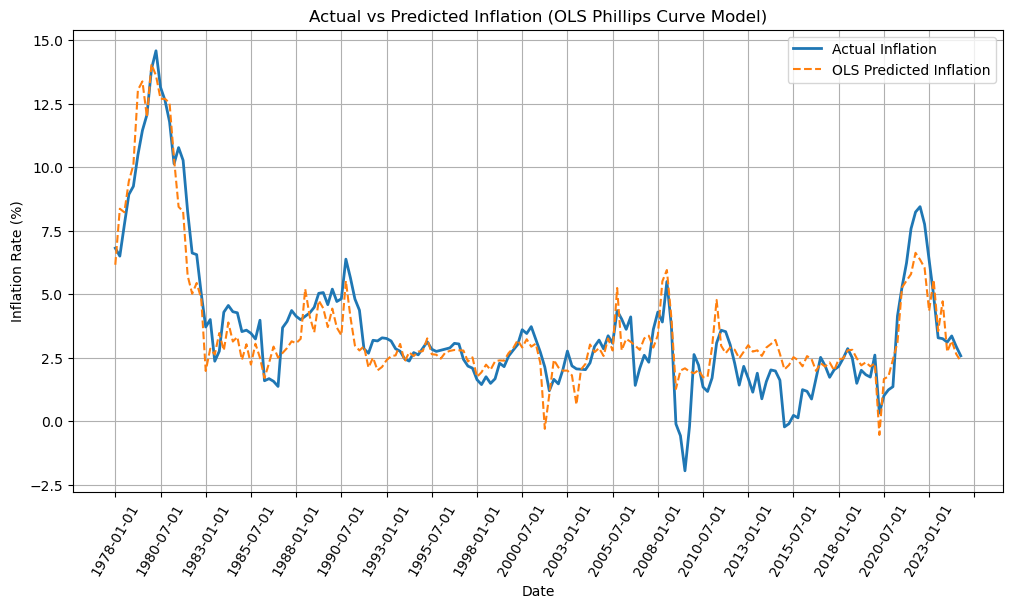

In [11]:
#target variable to be predicted
y = df['Inflation']  

#base model, pure philips curve
X = df[['Unemployment', 'InflationExpectations', 'OutputGap']]

#add a constant term to X for the intercept (β0)
X = sm.add_constant(X)

#building and fitting the OLS regression model
ols_model = sm.OLS(y, X).fit()

#print full model summary
print(ols_model.summary())


# predict inflation using the model
df['Predicted_Inflation_OLS'] = ols_model.predict(X)

#evaluating the model and save values for future use
print('Traditional OLS:')
r2_traditional_OLS = r2_score(y, df['Predicted_Inflation_OLS'])
print('R2:', r2_traditional_OLS)
mae_traditional_OLS = mean_absolute_error(y, df['Predicted_Inflation_OLS'])
print('MAE:', mae_traditional_OLS)
rmse_traditional_OLS = np.sqrt(mean_squared_error(y, df['Predicted_Inflation_OLS']))
print('RMSE:', rmse_traditional_OLS)

#plot actual vs predicted inflation
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Inflation'], label='Actual Inflation', linewidth=2)
plt.plot(df.index, df['Predicted_Inflation_OLS'], label='OLS Predicted Inflation', linestyle='--')
plt.title('Actual vs Predicted Inflation (OLS Phillips Curve Model)')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')

#inspired by: https://stackoverflow.com/questions/74614017/change-x-tick-intervals-when-using-matplotlib-pyplot
plt.xticks(ticks = list(range(0,200,10)),rotation = 60)

plt.legend()
plt.grid(True)
plt.show()

#### 6. Build RandomForest & GradientBoosting (GBR) Models for Pure Data Driven,  Tuned HyperParameters

##### 6.1. Random Forest

This model uses a Random Forest Regressor, a machine learning algorithm capable of capturing complex, nonlinear relationships between variables. It is trained on a wide set of economic indicators beyond traditional theory, using a data-driven approach. Hyperparameters were tuned through GridSearchCV to optimize model performance and avoid overfitting. The Random Forest model will be compared against the traditional OLS model to assess whether a pure data-driven machine learning approach can improve the accuracy and robustness of U.S. inflation forecasting.

If the difference between the Training and Testing R2 is less than 0.1, model is not Overfitting
Train R2: 0.9841832255873725
Test R2 : 0.9258391493589441

Random Forest(Data-driven):
R2: 0.9258391493589441
MAE: 0.6131574259967366
RMSE: 0.7912369864035584


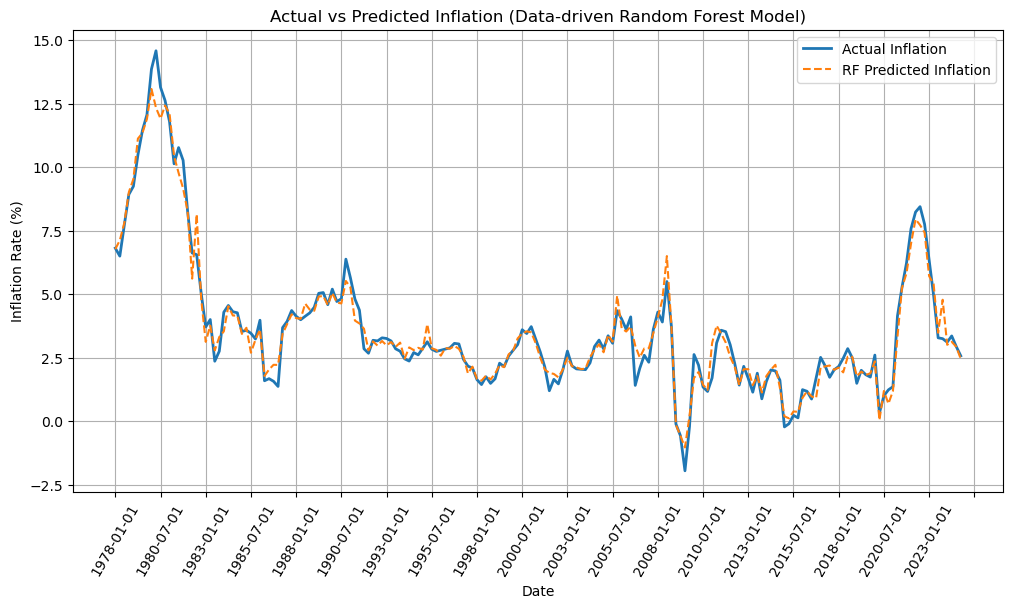

In [12]:
#target variable to be predicted
y = df['Inflation']  

#pure data-driven so all other variables
X = df[['Unemployment', 'InflationExpectations', 'OutputGap', 'FFR', 'LaborForceParticipation', 'CapacityUtilization' ]]

#splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

#hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

#creating the Random Forest Regressor model with tuned hyperparameter
grid_rf = GridSearchCV(RandomForestRegressor(n_estimators=100, random_state=42), param_grid_rf, cv=3, scoring='neg_mean_absolute_error')
grid_rf.fit(X_train, y_train)

#select the best model
best_rfd = grid_rf.best_estimator_


#training the model
best_rfd.fit(X_train, y_train)

#making predictions
y_pred_rf = best_rfd.predict(X_test)
df['Predicted_Inflation_RF'] = best_rfd.predict(X) 

#Check if we are overfitting
print("If the difference between the Training and Testing R2 is less than 0.1, model is not Overfitting")
print("Train R2:", r2_score(y_train, best_rfd.predict(X_train)))
print("Test R2 :", r2_score(y_test, best_rfd.predict(X_test)))
print("")


#evaluating the model
print('Random Forest(Data-driven):')
r2_ddRF = r2_score(y_test, y_pred_rf)
print('R2:', r2_ddRF)
mae_ddRF = mean_absolute_error(y_test, y_pred_rf)
print('MAE:', mae_ddRF)
rmse_ddRF = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print('RMSE:', rmse_ddRF)

# Plotting Actual vs Predicted Inflation
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Inflation'], label='Actual Inflation', linewidth=2)
plt.plot(df.index, df['Predicted_Inflation_RF'], label='RF Predicted Inflation', linestyle='--')
plt.title('Actual vs Predicted Inflation (Data-driven Random Forest Model)')
plt.xlabel('Date')

#inspired by: https://stackoverflow.com/questions/74614017/change-x-tick-intervals-when-using-matplotlib-pyplot
plt.xticks(ticks = list(range(0,200,10)),rotation = 60)

plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

##### 6.2. GradientBoosting (GBR) Model

This model uses a Gradient Boosting Regressor, a machine learning algorithm designed to capture complex, nonlinear relationships between economic variables. It is trained on a broad set of macroeconomic indicators beyond the traditional Phillips Curve framework, taking a fully data-driven approach. Hyperparameters were tuned using GridSearchCV to optimize model performance and avoid overfitting. The Gradient Boosting model will be compared against the traditional OLS benchmark to evaluate whether pure data-driven machine learning techniques can improve the accuracy and stability of U.S. inflation forecasting.

If the difference between the Training and Testing R2 is less than 0.1, model is not Overfitting
Train R2: 0.9841832255873725
Test R2 : 0.9258391493589441

GradientBoostingRegressor(Data-driven):
R2: 0.9258391493589441
MAE: 0.6131574259967366
RMSE: 0.7912369864035584


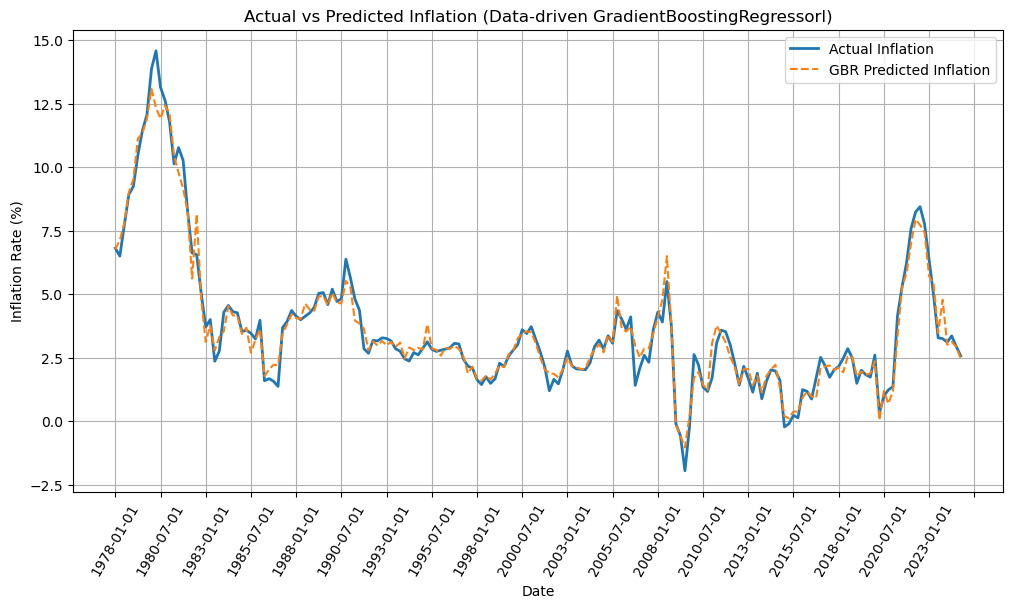

In [13]:
#target variable to be predicted
y = df['Inflation']  

#pure data-driven so all other variables
X = df[['Unemployment', 'InflationExpectations', 'OutputGap', 'FFR', 'LaborForceParticipation', 'CapacityUtilization' ]]

#splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

#hyperparameter grid
param_grid_GBR = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

#creating the Gradient Boosting Regressor model with tuned hyperparameter
grid_gbr = GridSearchCV(GradientBoostingRegressor(n_estimators=100, random_state=42), param_grid_GBR, cv=3, scoring='neg_mean_absolute_error')
grid_gbr.fit(X_train, y_train)

#select the best model
best_gbr = grid_rf.best_estimator_


#training the model
best_gbr.fit(X_train, y_train)

#making predictions
y_pred_gbr = best_gbr.predict(X_test)
df['Predicted_Inflation_GBR'] = best_gbr.predict(X) 

#Check if we are overfitting
print("If the difference between the Training and Testing R2 is less than 0.1, model is not Overfitting")
print("Train R2:", r2_score(y_train, best_rfd.predict(X_train)))
print("Test R2 :", r2_score(y_test, best_rfd.predict(X_test)))
print("")

#evaluating the model
print('GradientBoostingRegressor(Data-driven):')
r2_GBR = r2_score(y_test, y_pred_gbr)
print('R2:', r2_GBR)
mae_GBR = mean_absolute_error(y_test, y_pred_gbr)
print('MAE:', mae_GBR)
rmse_GBR = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
print('RMSE:', rmse_GBR)

# Plotting Actual vs Predicted Inflation
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Inflation'], label='Actual Inflation', linewidth=2)
plt.plot(df.index, df['Predicted_Inflation_GBR'], label='GBR Predicted Inflation', linestyle='--')
plt.title('Actual vs Predicted Inflation (Data-driven GradientBoostingRegressorl)')
plt.xlabel('Date')

#inspired by: https://stackoverflow.com/questions/74614017/change-x-tick-intervals-when-using-matplotlib-pyplot
plt.xticks(ticks = list(range(0,200,10)),rotation = 60)
 
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

#### 7. Build RandomForest & GradientBoosting (GBR) Models for Theory Driven,  Tune HyperParameters

##### 7.1. Random Forest

This model uses a Random Forest Regressor, a machine learning algorithm capable of capturing complex, nonlinear relationships between variables. It is trained only on three key variables, Unemployment Rate, Inflation Expectations, and Output Gap, based on established economic theory. Hyperparameters are tuned through GridSearchCV to optimize model performance and avoid overfitting. This theory based Random Forest model will be compared against the traditional OLS model to assess whether a theory based machine learning approach can improve the accuracy and robustness of U.S. inflation forecasting.

If the difference between the Training and Testing R2 is less than 0.1, model is not Overfitting
Train R2: 0.9269713837505114
Test R2 : 0.8783007401347753

Random Forest(Theory based ML):
R2: 0.8783007401347753
MAE: 0.7645989216031046
RMSE: 1.0135920542519454


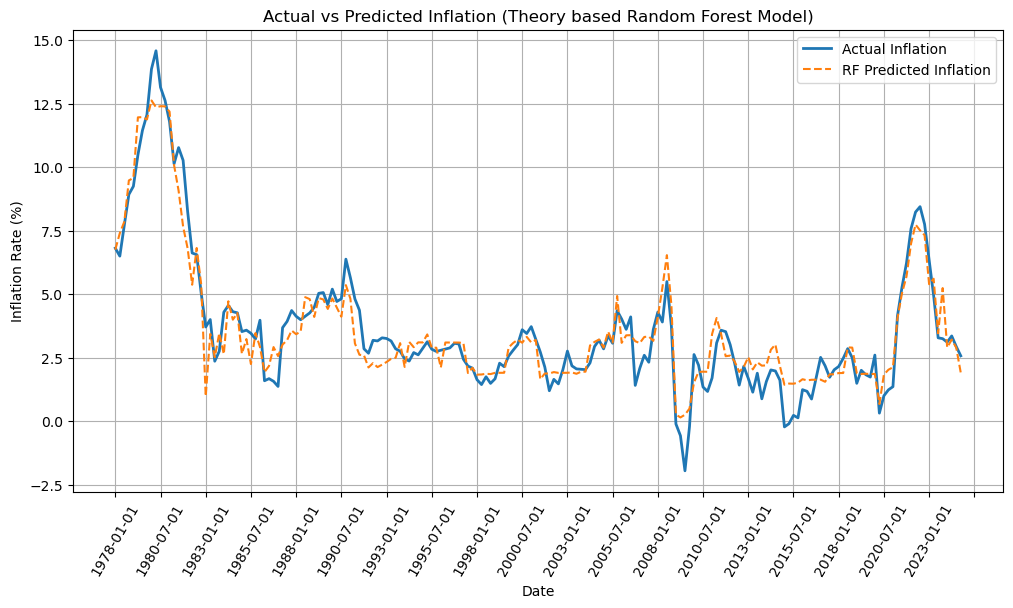

In [14]:
#target variable to be predicted
y = df['Inflation']  

#theory driven bt pure philips curve so constrained to only 3 variables
X = df[['Unemployment', 'InflationExpectations', 'OutputGap']]

#splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

#hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

#creating the Random Forest Regressor model with tuned hyperparameter
grid_rf = GridSearchCV(RandomForestRegressor(n_estimators=100, random_state=42), param_grid_rf, cv=3, scoring='neg_mean_absolute_error')
grid_rf.fit(X_train, y_train)

#select the best model
best_rf = grid_rf.best_estimator_


#training the model
best_rf.fit(X_train, y_train)

#making predictions
y_pred_rf = best_rf.predict(X_test)
df['Predicted_Inflation_RFT'] = best_rf.predict(X) 

#Check if we are overfitting
print("If the difference between the Training and Testing R2 is less than 0.1, model is not Overfitting")
print("Train R2:", r2_score(y_train, best_rf.predict(X_train)))
print("Test R2 :", r2_score(y_test, best_rf.predict(X_test)))
print("")

#evaluating the model
print('Random Forest(Theory based ML):')
r2_tdRF = r2_score(y_test, y_pred_rf)
print('R2:', r2_tdRF)
mae_tdRF = mean_absolute_error(y_test, y_pred_rf)
print('MAE:', mae_tdRF)
rmse_tdRF = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print('RMSE:', rmse_tdRF)

# Plotting Actual vs Predicted Inflation
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Inflation'], label='Actual Inflation', linewidth=2)
plt.plot(df.index, df['Predicted_Inflation_RFT'], label='RF Predicted Inflation', linestyle='--')
plt.title('Actual vs Predicted Inflation (Theory based Random Forest Model)')
plt.xlabel('Date')

#inspired by: https://stackoverflow.com/questions/74614017/change-x-tick-intervals-when-using-matplotlib-pyplot
plt.xticks(ticks = list(range(0,200,10)),rotation = 60)
 
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

##### 7.2. GradientBoosting (GBR) Model

This model uses a Gradient Boosting Regressor, a machine learning algorithm designed to capture complex, nonlinear relationships between economic variables. It is trained only on three key variables, Unemployment Rate, Inflation Expectations, and Output Gap, based on established economic theory. Hyperparameters were tuned using GridSearchCV to optimize model performance and avoid overfitting. The Gradient Boosting model will be compared against the traditional OLS benchmark to evaluate whether theory-driven machine learning techniques can improve the accuracy and stability of U.S. inflation forecasting.

If the difference between the Training and Testing R2 is less than 0.1, model is not Overfitting
Train R2: 0.9269713837505114
Test R2 : 0.8783007401347753

GradientBoostingRegressor(Theory based):
R2: 0.8783007401347753
MAE: 0.7645989216031046
RMSE: 1.0135920542519454


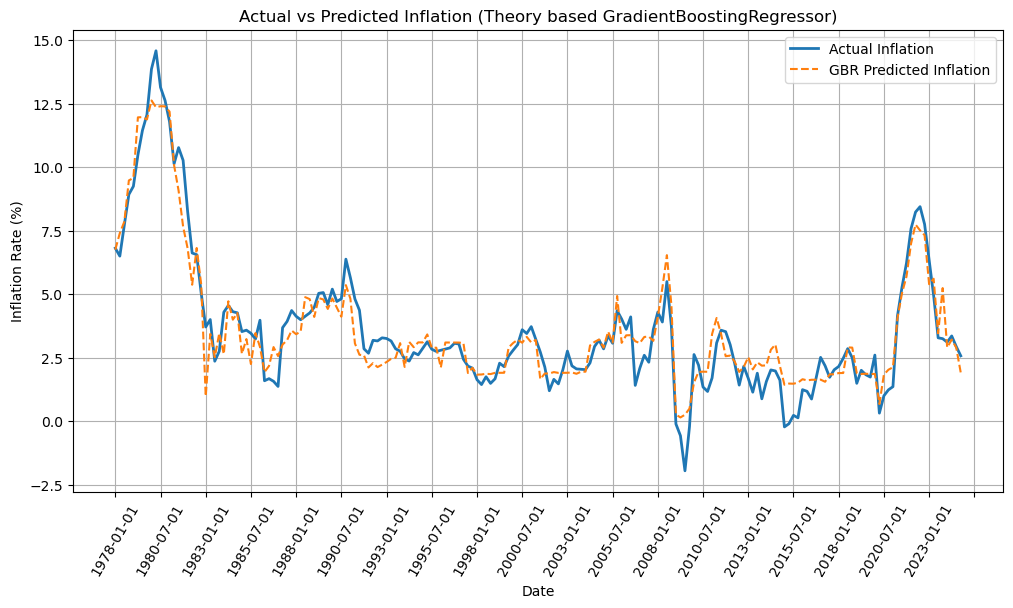

In [15]:
#splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

#hyperparameter grid
param_grid_GBR = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

#creating the Gradient Boosting Regressor model with tuned hyperparameter
grid_gbr = GridSearchCV(GradientBoostingRegressor(n_estimators=100, random_state=42), param_grid_GBR, cv=3, scoring='neg_mean_absolute_error')
grid_gbr.fit(X_train, y_train)

#select the best model
best_gbr = grid_rf.best_estimator_


#training the model
best_gbr.fit(X_train, y_train)

#making predictions
y_pred_gbr = best_gbr.predict(X_test)
df['Predicted_Inflation_GBRT'] = best_gbr.predict(X) 

#Check if we are overfitting
print("If the difference between the Training and Testing R2 is less than 0.1, model is not Overfitting")
print("Train R2:", r2_score(y_train, best_rf.predict(X_train)))
print("Test R2 :", r2_score(y_test, best_rf.predict(X_test)))
print("")

#evaluating the model
print('GradientBoostingRegressor(Theory based):')
r2_tdGBR = r2_score(y_test, y_pred_gbr)
print('R2:', r2_tdGBR)
mae_tdGBR = mean_absolute_error(y_test, y_pred_gbr)
print('MAE:', mae_tdGBR)
rmse_tdGBR = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
print('RMSE:', rmse_tdGBR)

# Plotting Actual vs Predicted Inflation
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Inflation'], label='Actual Inflation', linewidth=2)
plt.plot(df.index, df['Predicted_Inflation_GBRT'], label='GBR Predicted Inflation', linestyle='--')
plt.title('Actual vs Predicted Inflation (Theory based GradientBoostingRegressor)')
plt.xlabel('Date')

#inspired by: https://stackoverflow.com/questions/74614017/change-x-tick-intervals-when-using-matplotlib-pyplot
plt.xticks(ticks = list(range(0,200,10)),rotation = 60)

plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

#### 8. Model Evaluations

Now, we assess the performance of all models, OLS, Random Forest, and Gradient Boosting, across both pure machine learning and theory-driven feature sets. We use standard error metrics including Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R2 to compare how well each model predicts U.S. inflation. We also introduce directional accuracy as a practical measure of whether models correctly forecast the directional movement of inflation over time. Results are summarized both in a comparison table and visually through bar plots, to provide a clear understanding of each model’s strengths and tradeoffs. This multi-metric approach allows us to evaluate not just accuracy, but also interpretability, stability, and practical forecasting value.

##### 8.1. R2, MAE, and RMSE

In [16]:
#function to return model evaluation in a desirable format
def evaluate_model(name, mae, rmse, r2):
    return {'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

#now find results for each model and append to the list
results = []

results.append(evaluate_model("OLS (Theory)", mae_traditional_OLS, rmse_traditional_OLS, r2_traditional_OLS))
results.append(evaluate_model("RF (Pure Data)", mae_ddRF, rmse_ddRF, r2_ddRF))
results.append(evaluate_model("GBR (Pure Data)", mae_GBR, rmse_GBR, r2_GBR))
results.append(evaluate_model("RF (Theory)", mae_tdRF, rmse_tdRF, r2_tdRF))
results.append(evaluate_model("GBR (Theory)", mae_tdGBR, rmse_tdGBR, r2_tdGBR))


#print results
results_df = pd.DataFrame(results)
results_df = results_df[['Model', 'MAE', 'RMSE', 'R2']]
print(results_df)



             Model       MAE      RMSE        R2
0     OLS (Theory)  0.817104  1.061259  0.852222
1   RF (Pure Data)  0.613157  0.791237  0.925839
2  GBR (Pure Data)  0.613157  0.791237  0.925839
3      RF (Theory)  0.764599  1.013592  0.878301
4     GBR (Theory)  0.764599  1.013592  0.878301


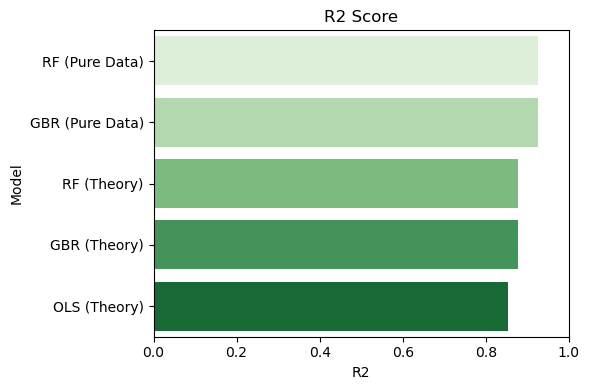

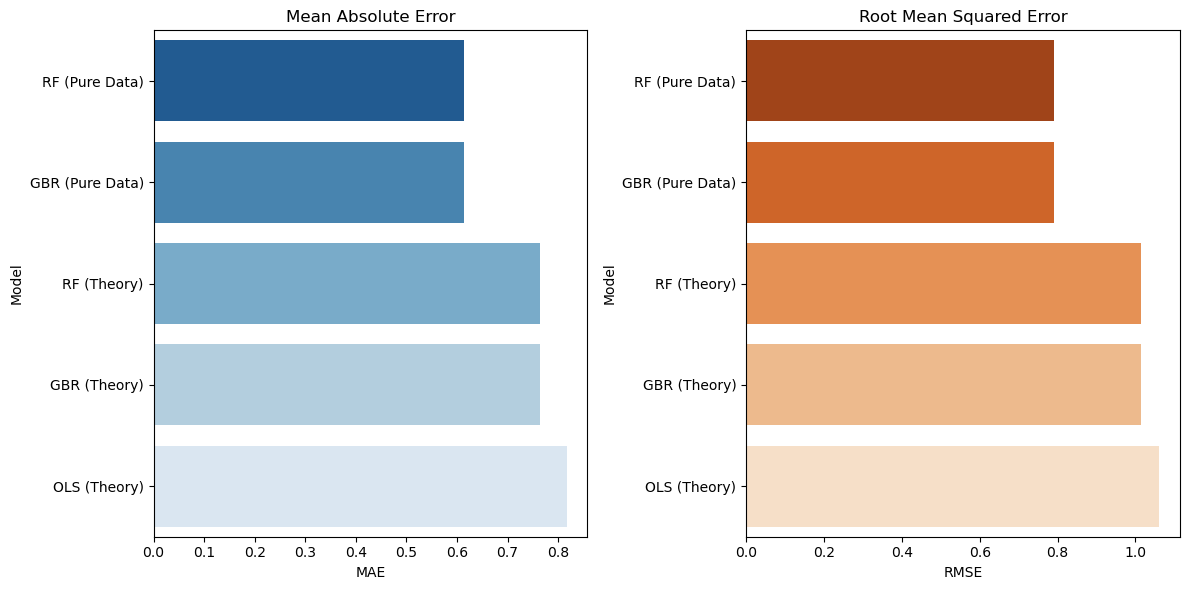

In [17]:
#the following code for plotting the eveluation metrics is inspired by: 
#https://seaborn.pydata.org/generated/seaborn.barplot.html

#plot R2
plt.figure(figsize=(6, 4))
results_df_sorted_r2 = results_df.sort_values('R2', ascending=False)

sns.barplot(x='R2', y='Model', data=results_df_sorted_r2, palette='Greens', hue='Model')
plt.title('R2 Score')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
results_df_sorted = results_df.sort_values('MAE')

#plot MAE
plt.subplot(1, 2, 1)
sns.barplot(x='MAE', y='Model', data=results_df_sorted, palette='Blues_r', hue='Model')
plt.title('Mean Absolute Error')

#plot RMSE
plt.subplot(1, 2, 2)
sns.barplot(x='RMSE', y='Model', data=results_df_sorted, palette='Oranges_r', hue='Model')
plt.title('Root Mean Squared Error')

plt.tight_layout()
plt.show()

As shown in the above tables and graphs, both Random Forest and Gradient Boosting models trained on the full set of macroeconomic indicators achieved lower prediction errors (MAE and RMSE) and higher R2 scores compared to the traditional OLS model and the theory-guided machine learning models. This suggests that a pure data-driven machine learning approach may offer improved forecasting accuracy over traditional or theory-constrained models when applied to U.S. inflation. However, the theory-guided ML models, which relied only on variables from the Phillips Curve framework, still outperformed the OLS baseline, indicating that even within constrained feature sets, machine learning can extract more nuanced relationships. These results highlight the potential of combining economic intuition with machine learning flexibility, offering a middle ground that improves accuracy while retaining interpretability.

During model evaluation, we have also considered the potential for overfitting, especially given the high performance scores achieved by the pure machine learning models. To assess this, we compared training and test R2 values and found only a small gap, suggesting good generalization(this comparison is done right after each individual model construction). Additionally, our use of hyperparameter tuning via GridSearchCV helped control model complexity and mitigate overfitting risks. 

##### 8.2. Directional Accuracy

In [18]:
#let's test directional accuracy here
def directional_accuracy(actual, predicted):
    actual_change = actual.diff().apply(lambda x: 1 if x > 0 else 0)
    predicted_change = predicted.diff().apply(lambda x: 1 if x > 0 else 0)
    mask = actual_change.notna() & predicted_change.notna()
    correct = (actual_change[mask] == predicted_change[mask]).sum()
    total = len(actual_change[mask])
    return correct / total

#directional accuracy report
print("Directional Accuracy:")

print("OLS (Base Model):", directional_accuracy(df['Inflation'], df['Predicted_Inflation_OLS']))
print("RF (Pure Data):", directional_accuracy(df['Inflation'], df['Predicted_Inflation_RF']))
print("GBR (Pure Data):", directional_accuracy(df['Inflation'], df['Predicted_Inflation_GBR']))
print("RF (Theory):", directional_accuracy(df['Inflation'], df['Predicted_Inflation_RFT']))
print("GBR (Theory):", directional_accuracy(df['Inflation'], df['Predicted_Inflation_GBRT']))


Directional Accuracy:
OLS (Base Model): 0.6595744680851063
RF (Pure Data): 0.7872340425531915
GBR (Pure Data): 0.7872340425531915
RF (Theory): 0.6702127659574468
GBR (Theory): 0.6702127659574468


When comparing the models based on directional accuracy, their ability to correctly predict whether inflation would rise or fall, the pure machine learning models performed the best, with both Random Forest and Gradient Boosting correctly predicting the direction of inflation approximately 79% of the time. This significantly outperformed the OLS model, which achieved only 66% directional accuracy. The theory based machine learning models also showed moderate improvement over OLS, with directional accuracy of 67%. These results suggest that while theory based models offer some benefit, allowing machine learning models to utilize a broader range of macroeconomic indicators leads to more reliable detection of inflation trends. Refrence: https://support.numxl.com/hc/en-us/articles/360029220972-MDA-Mean-Directional-Accuracy

#### 9. Scenario Testing

Clearly the Pure Data Random Forest and Gradient Boositing Regressor models perform better than the other models so now let's perform scenario testing using known economic theory to further assess their robustness and practical validity using 2 realistic macroeconomic scenarios, each representing a different economic environment. This step helps determine not only the predictive strength of the models, but also their potential usefulness in real-world economic forecasting and policy analysis.

##### 9.1. Scenario 1: Recession/Negative Shock

Simulates an economic downturn like a financial crisis. Expected lower inflation due to slack in the economy and higher unemployment.

In [19]:
#feature set used in pure data Random Forest models
features_pure = ['Unemployment', 'InflationExpectations', 'OutputGap', 'FFR', 'LaborForceParticipation', 'CapacityUtilization']

#get the current econmomic situation
base = df[features_pure].iloc[-1].copy()

#this scenario tests deep recession with high unemployment rate, negative demand shock, people exiting workforce, 
#and thus higher inflation expectation
scenario_1 = base.copy()
scenario_1['Unemployment'] = 7.5
scenario_1['InflationExpectations'] = 1.0
scenario_1['OutputGap'] = -3.5
scenario_1['FFR'] = 2.0
scenario_1['LaborForceParticipation'] = 61.0
scenario_1['CapacityUtilization'] = 73.0

# Convert to DataFrame for prediction
scenario_df = pd.DataFrame([scenario_1])
predicted_inflation = best_rfd.predict(scenario_df)[0]

base_pred = best_rfd.predict(pd.DataFrame([base]))[0]
print("Baseline inflation prediction: ", base_pred)

print("Predicted inflation for the scenario: ", predicted_inflation)

Baseline inflation prediction:  2.4512582016624553
Predicted inflation for the scenario:  2.4032694047532392


##### 9.2. Scenario 2: Boom/Overheating Economy

Simulates rapid economic growth with tight labor markets. Expected higher inflation due to tight capacity and rising expectations.

In [20]:
#feature set used in pure data Random Forest models
features_pure = ['Unemployment', 'InflationExpectations', 'OutputGap', 'FFR', 'LaborForceParticipation', 'CapacityUtilization']

#get the current econmomic situation
base = df[features_pure].iloc[-1].copy()

#this scenario tests overheating economy with low unemployment rate, posetive demand shock, people entering workforce, 
#and thus lower inflation expectation
scenario_2 = base.copy()
scenario_2['Unemployment'] = 3.3
scenario_2['InflationExpectations'] = 3.7
scenario_2['OutputGap'] = 2.5
scenario_2['FFR'] = 1.5
scenario_2['LaborForceParticipation'] = 63.5
scenario_2['CapacityUtilization'] = 80.5

# Convert to DataFrame for prediction
scenario_df = pd.DataFrame([scenario_2])
predicted_inflation = best_rfd.predict(scenario_df)[0]

base_pred = best_rfd.predict(pd.DataFrame([base]))[0]
print("Baseline inflation prediction: ", base_pred)

print("Predicted inflation for the scenario: ", predicted_inflation)

Baseline inflation prediction:  2.4512582016624553
Predicted inflation for the scenario:  3.6986174419538727


Scenario testing showed that our data driven Random Forest model reacts in a sensible way to changes in the economy. When we simulated a recession, it predicted lower inflation, and when we modeled a booming economy, it predicted higher inflation. This suggests the model is picking up on the right signals and could be useful for real world inflation forecasting :)

## **

In [21]:
#checking feature importance
print("Feature importance:")
importances = best_rfd.feature_importances_
for feature, importance in zip(features_pure, importances):
    print(feature, ":", importance)

Feature importance:
Unemployment : 0.01388230146451979
InflationExpectations : 0.8244345618775547
OutputGap : 0.0170659929467462
FFR : 0.0932859593302088
LaborForceParticipation : 0.024876566046191595
CapacityUtilization : 0.02645461833477889


An important insight from the above featuere importance analyis is the model’s heavy reliance on inflation expectations which, interestingly, aligns with several modern macroeconomic theories—which see inflation expectations as a major driver of actual inflation e.g. https://www.nobelprize.org/prizes/economic-sciences/1995/advanced-information/, https://www.sciencedirect.com/science/article/abs/pii/S1059056016000058. However, it also highlights a potential limitation. In reality, expectations can sometimes be wrong or overridden by shocks, and their influence may vary across time periods. 

#### 10. Conclusion

In conclusion, this project set out to evaluate whether machine learning models could outperform the traditional Ordinary Least Squares (OLS) approach used by institutions like the Federal Reserve for forecasting U.S. inflation. Our results demonstrate that both versions of our models—purely data-driven and theory-guided Random Forest and Gradient Boosting Regressors—consistently outperformed the traditional OLS model(look at the graphs and comparison analysis in section 8 above). This was especially true during periods of economic turbulence such as the Great Recession and the COVID-19 pandemic, when nonlinear dynamics and structural shifts made linear models less reliable(look at the individual inflation prediction curves at these specific periods in earlier sections above).

One of the most important insights emerged from our feature importance analysis. Across all data-driven models, inflation expectations were repeatedly ranked as the most significant predictor of actual inflation. This strongly supports a key idea in modern macroeconomic theory particularly the New Keynesian framework and the expectations-augmented Phillips Curve which states that forward-looking behavior plays a central role in inflation dynamics (https://www.nobelprize.org/prizes/economic-sciences/1995/advanced-information/, https://www.sciencedirect.com/science/article/abs/pii/S1059056016000058). In essence, when people and firms expect inflation to rise, their behavior changes in ways that cause inflation to rise, making inflation expectations a self-fulfilling mechanism. Our model's empirical validation of this theory has powerful implications: it not only lends credibility to newer macroeconomic thinking, but also suggests that inflation forecasting models must incorporate expectations to remain relevant and accurate.

These findings have several implications for policymakers and forecasters. First, it indicates that modern machine learning models are valuable tools for enhancing inflation predictions, especially in rapidly changing or unprecedented economic conditions. Second, it reaffirms the importance of monitoring and managing inflation expectations, not just inflation itself, when designing monetary policy. A data-driven confirmation of this relationship can help central banks fine-tune their communications and policy levers to stabilize expectations and, by extension, actual inflation.

However, some limitations persist. Machine learning models, while flexible and accurate, can be prone to overfitting and often lack the transparency of traditional models. This can make them harder to interpret in policy settings, where clarity and theoretical grounding are crucial. Additionally, our models rely heavily on historical data and may need regular retraining to stay relevant in new economic regimes. However, we have taken active measures to avoid overfitting by tuning hyperparameters and seeing the difference of R2 values between testing and training sets to ensure generalizability.

Ultimately, this project suggests that <b>machine learning models should not be viewed as replacements for traditional economic models, but as powerful complements.</b> Their strength lies in pattern recognition and adaptability, while theory-based models provide explanatory clarity. Used together, they can offer more accurate and reliable inflation forecasting tools.

For future work, exploring additional economic indicators and integrating real-time data streams would be valuable next steps. Furthermore, exploring neural networks, which may be better suited to capturing sequential dynamics in macroeconomic data, if more historical or high-frequency data becomes available, is also an exciting area of future work.